# Der g-h-Filter am Beispiel eines Abstandssensors
6.7.2019, S. Mack

In [17]:
#to render plots inside this notebook
%matplotlib inline
# import of python packages
import matplotlib.pyplot as plt

Nachfolgend werden die Python Packlages  `SciPy` (scipy.org), `NumPy` (numpy.org) und `Matplotlib` (matplotlib.org) verwendet. Der obige Python-Code ist für die Darstellung von Grafiken und Text in diesem Jupyter-Notebook nötig.  

Als Anwendungsbeispiel wird hier die Abstandssensorik am Roboterfahrzeug des Projekts "Sensor- und Mikrosysteme" im Masterstudium Mechatronik an der Hochschule Reutlingen verwendet:  

<img src="RoboFahrzeugParallel.png" width="400">
  
Das Fahrzeug soll wie in der Zeichnung oben dargestellt in einem konstanten Abstand an der Wand entlang fahren. Der Abstand wird z.B. mit einem am Fahrzeug angebrachten Lidarsensor gemessen und dient als Eingangssignal für eine Regelung.  

## Statische Abstandsmessungen
Das Fahrzeug steht parall zur Wand, der Lidar-Abstandssensor am Fahrzeug ist senkrecht zur Fahrtrichtung auf die Wand ausgerichtet.  
Der Sensor besitzt einen vernachlässigbaren Offsetfehler, da dieser vorher durch eine Kalibrierung auf weniger als 5 mm reduziert wurde. Da auf eine ebene Wand gemessen wird, und keine Mehrfachreflexe durch andere Objekte im Lichtkegel des Sensors entstehen, kommt kein weiterer systematischer Messfehler hinzu. Ein möglicher Linearitätsfehler ist aufgrund der Laufzeitmessung zu vernachlässigen.  
*Somit ist der Sensormesswert nur mit einem statistischen Fehler behaftet, der durch Rauschen der Sensorelektronik, durch Fremdlicht oder durch elektrische Störeinkopplungen verursacht wird.*  
Wiederholt man die Messung bei stehendem Roboter, so streuen die Messwerte mit einer Normal- bzw. Gaußverteilung. Der wahre Abstand ist dabei der Erwartungswert. Die Breite der Streuung wird über die Standardabweichung $\sigma$ quantifiziert: Ein Vertrauensniveau von 99,73 % entspricht z.B. $3 \sigma$.   
### Gedankenexperiment
Angenommen, man kennt die Standardabweichung des Abstandssensors (also dessen statistische Messunsicherheit) und darf aus Zeitgründen nur eine Messung vornehmen. Damit ergibt sich beispielsweise ein Messergebnis von 160 mm bei einer Messunsicherheit von 9 mm ($3 \sigma$) für diese Messung A.  
Was ändert sich, wenn zeitgleich eine weitere Messung B mit einem zusätzlichen, baugleichen Sensor durchgeführt wird? Die zweite Messung hat beispielsweise das Ergebnis 170 mm. Die Messunsicherhet ist hier ebenfalls 9 mm, da es sich ja um den *baugleichen* Sensor handelt.  

#### Interpretation der Messung zweier Sensoren A und B

Obwohl sich der Roboter nicht bewegt hat, differieren beide Messungen. Dies ist nicht wirklich verwunderlich, zumal beide Messungen einen statistischen Messfehler aufweisen. **Wie kann man *beide* Messungen A und B gemeinsam berücksichtigen, also "fusionieren", um näher an den wahren Abstandswert zu kommen?**  

Welche Optionen zur Messwertinterpretation gibt es?

1. Nur dem Sensor A vertrauen.
2. Nur dem Sensor B vertrauen.
3. Annehmen, der wahre Abstand sei größer als beide Messwerte von Sensor A und B.
4. Annehmen, der wahre Abstand sei kleiner als beide Messwerte von Sensor A und B.
5. Annehmen, der wahre Abstand liege zwischen den Messwerten von Sensor A und B.

Die ersten beiden Optionen sind noch halbwegs plausibel. Aber wenn man keinen Anhaltspunkt dafür hat, wieso gerade nur eine der beiden Messungen gestört wurde, dann lässt sich für diese Optionen nur schwer argumentieren.  
Die Optionen drei und vier sind von vorne herein unplausibel. Es ist unwahrscheinlich, dass beide Messungen eine Abweichung mit selben Vorzeichen haben.  
Am wahrscheinlichsten ist es, dass die eine Messung über und die andere Messung unter dem wahren Wert liegt. Genau wie bei zweimaligem Würfeln ist es wahrscheinlicher, dass am Ende eine Augenzahl $\geq$3 und eine $\leq$3 heraus kommt, als dass zweimal $\geq$3 oder $\leq$3 Augen geworfen werden.

Die beste Schätzung für den wahren Abstandswert ist also (160 mm +170 mm)/2 = 165 mm.

Dies lässt sich auch grafisch verdeutlichen mit zwei Messpunkten bei 160 bzw. 170 mm, die jeweils mit  $\pm$ 9 mm langen Fehlerbalken versehen sind. Auch hier ist intuitiv klar: Der wahre Abstandswert liegt im Überlappbereich der beiden Fehlerbalken.

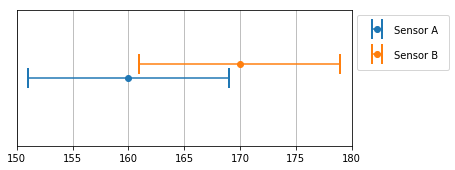

In [18]:
def plot_errorbars(bars, xlims, ylims=(-1, 1)): # plot function will be used later again
    plt.figure(figsize=(6,2.5))
    i = 0.0
    for bar in bars:
        plt.errorbar([bar[0]], [i], xerr=[bar[1]], fmt='o', label=bar[2] , capthick=2, capsize=10)
        i += 0.2
    plt.ylim(-1,1)
    plt.xlim(xlims[0], xlims[1])
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),borderpad=1, labelspacing=1.5)
    plt.gca().axes.yaxis.set_ticks([]) # no ticks on y-axis
    plt.grid()
    
plot_errorbars([(160, 9, 'Sensor A'), (170, 9, 'Sensor B')], xlims=(150, 180))

Bisher wurden beide Sensoren als baugleich angenommen. Dies war mit ein Grund für die Annahme, der wahre Abstandswert läge genau in der Mitte des Überlappbereichs der beiden Fehlerbalken.

Was ändert sich, wenn beide Sensoren einen unterschiedlichen statistischen Messfehler aufweisen. Zum Beispiel hat Sensor A jetzt nur mit $\pm$ 3 mm nur noch eine 1/3 so große Messunsicherheit wie Sensor B mit $\pm$ 9 mm. Dann überlappen beide Fehlerbalken immer noch, wie der nachfolgende Plot darstellt.

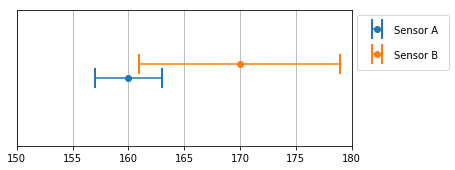

In [19]:
plot_errorbars([(160, 3, 'Sensor A'), (170, 9, 'Sensor B')], xlims=(150, 180))

Betrachtet man jetzt wieder die fünf Optionen der Messwertinterpretation, so liegt die Idee nahe, nur Sensor A zu vertrauen. Denn er liefert offensichtlich die genaueren Messwerte. Daraus ergäbe sich 160 mm als plausible Annahme des wahren Abstands.  
Doch eigentlich kann der wahre Abstand nicht 160 mm betragen. Denn Sensor B hätte dann unterhalb $3 \sigma$ abweichen müssen, was nur mit einer Wahrscheinlichkeit von $(1-0,9973)/2 = 0,14 \%$ vorkommt - also sehr unwahrscheinlich ist.  

Mit Blick auf den Plot oben ist ein wahrer Wert von 162 mm am plausibelsten.  

> Es wäre also falsch, den Messwert mit der höheren Unsichert zu ignorieren. Selbst ein schlechter Messwert ist immer noch besser als keiner!

Im nächsten Plot ist die Situation weiter zugespitzt: Sensor A hat nun $\pm$ 2 mm und Sensor B $\pm$ 8 mm statistische Messunsicherheit:

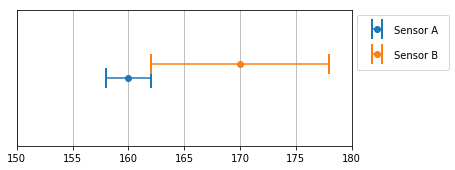

In [20]:
plot_errorbars([(160, 2, 'Sensor A'), (170, 8, 'Sensor B')], xlims=(150, 180))

Jetzt ist 162 mm der einzig plausible Wert für den Abstand. Zwei recht ungenaue Sensoren führen also zu einem fusionierte Messwert, der sehr genau ist.  
>**Zwei Sensoren sind immer besser als einer, selbst wenn der zweite Sensor im Vergleich zum ersten sehr ungenau ist.** Selbst die Fusion mit einem weniger genauen Sensormesswert ist sinnvoll.

Angenommen, die beiden Messwerte stammen nicht von zwei unterschiedlichen Sensoren sondern von ein und dem selben Sensor und wurden kurz nacheinander ausgeführt, ohne dass ich das Fahrzeug gegenüber der Wand bewegt hat?  
An der statistischen Analyse ändert sich nichts. Beide Messungen können auch eine unterschiedliche Messunsicherheit aufweisen, weil bei der zweiten Messung vielleicht mehr Störschall vorhanden war. Es gibt tatsächlich Sensoren, die bei jeder Messung die Standardabweichung mit ausgeben, wie zum Beispiel die Lidar-Sensoren von STMicroelectronics.

## Wahrscheinlichkeitsdichteverteilungen
In den Plots oben deuten die Fehlerbalken an, dass der Messwert innerhalb dieser Bereiche mit gleicher Wahrscheinlichkeit streut. Diese "Wahrscheinlichkeitsdicheverteilung" nennt man eine Gleichverteilung. Über das ``NumPy`` Package wird eine solche Verteilung wie folgt generiert:

In [21]:
import numpy as np
measurements = np.random.uniform(160, 170, size=10000)
mean = measurements.mean()
print('Mittelwert Gleichverteilung: {:.4f}'.format(mean))

Mittelwert Gleichverteilung: 164.9788


Hier wurde eine gleichverteilte Zufallsgröße zwischen 160 und 170 generiert und in ein Array abgespeichert. Diese Stichprobe hat 10000 Elemente. Der Mittelwert ist wie zu erwarten nahe am Erwartungswert von 165. Erwartungswert nennt man den Wert, gegen den der Mittelwert für eine sehr große Stichprobe hin konvergiert.

Das Streuverhalten der Messwerte eines Abstandssensors wird durch eine Gleichverteilung nicht richig beschrieben. Eigentlich jeder Sensor gibt mit einer höheren Wahrscheinlichkeit einen Messwert aus, der nahe am wahren Wert liegt, als einen sogenannten "Ausreißer".  
Die Normalverteilung, oder Gaußverteilung, im Package ``NumPy``, repräsetiert durch ``numpy.random.normal()``, modelliert sehr viel besser das reale Sensorverhalten als eine Gleichverteilung.  
Stellt man sich die Messwertstreuung eines Sensors als Ergebnis vieler kleiner Störfaktoren vor, dann kann man sogar über den "zentralen Grenzwertsatz" mathematisch beweisen, dass die Normalverteilung am besten dem realen Sensorverhalten entspricht.

In [22]:
mean = np.random.normal(165, 5, size=10000).mean()
print('Mittelwert Normalverteilung: {:.4f}'.format(mean))

Mittelwert Normalverteilung: 164.9945


## Abstandsmessung bei bewegtem Fahrzeug
Nun soll das Fahrzeug entlang der Wand fahren und mit seinem (einen) Abstandssensor jede Sekunde den Abstand zur Wand messen. Der Takt der Messungen wird als "*Abtastzeit*" bezeichnet. Der zeitliche Verlauf dieser Messung könnte so aussehen wie im nachfolgendem Plot, welcher drei aufeinander folgende Messwerte darstellt:

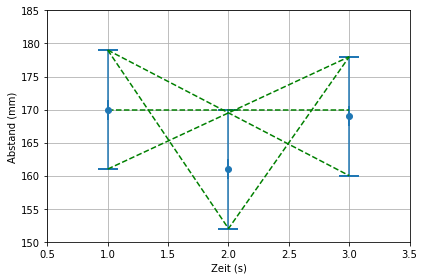

In [23]:
plt.figure()
plt.errorbar([1, 2, 3], [170, 161, 169],xerr=0, yerr=9, fmt='o', capthick=2, capsize=10)

plt.plot([1, 3], [179, 160], color='g', ls='--')
plt.plot([1, 3], [170, 170], color='g', ls='--')
plt.plot([1, 3], [161, 178], color='g', ls='--')
plt.plot([1, 2, 3], [179, 152, 178], color='g', ls='--')
plt.xlim(0.5,3.5)
plt.ylim(150, 185)
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
plt.grid()
plt.tight_layout()

**Aus dem zeitlichen Verlauf der drei Abstandsmessungen lassen sich völlig unterschiedliche mögliche Bewegungsverläufe des Fahrzeugs interpretieren, von denen die extremen mit grün gestrichelten Linien dargestellt sind:  
Das Fahrzeug kann schräg zur Wand hin oder weg fahren. Auch kann es perfekt parallel zu Wand oder in einem Zickzack-Kurs fahren.**

### Bestimmung des plausibelsten Bewegungsverlaufs mittels verrauschter Messwerte  
Was ist der plausibelste Bewegungsverlauf? Die Antwort darauf wird einfacher, wenn das physikalische System (=Fahrzeug) bekannt ist: Hat das Fahrzeug beispielsweise keine Lenkung und wurde es beim Start exakt parallel zur Wand ausgerichtet, dann wäre die Hypothese der exakt parallelen Bewegung zu Wand am plausibelsten.  
>**Das Wissen über das physikalische System, genauer gesagt ein Modell davon, beeinflusst die Interpretation der an ihm vorgenommenen Messwerte.**  

Je mehr aufeinander folgende Messwerte vorhanden sind, desto besser können die Messwerte mit Hilfe des physikalischen Modells erklärt werden. Der nachfolgende Plot zeigt einen neuen Messwerteverlauf über 12 Sekunden. 
 

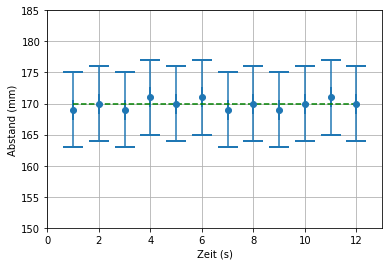

In [24]:
plt.figure()
plt.errorbar(range(1, 13), [169, 170, 169,171, 170, 171, 169, 170, 169, 170, 171, 170],
    xerr=0, yerr=6, fmt='o', capthick=2, capsize=10)
plt.plot([1, 12], [169.9, 169.9], color='g', ls='--')       
plt.xlim(0, 13)
plt.ylim(150, 185)
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
plt.grid()

Ein plausibler Verlauf der wahren Abstandswerte ist hier grün gestrichelt dargestellt. Es wäre auch möglich eine Zickzack-Bewegung an die Messdaten anzupassen. Aber in Kenntnis des physikalischen Modells (Fahrzeug ohne Lenkung, paralleler Start zur Wand) ist die Zick-Zack-Bewegung sehr unwahrscheinlich.  
Die grün gestrichelte Linie muss nicht den wahren Verlauf der Wandabstände repräsentieren. Jedoch steht sie für einen Bewegungsverlauf, welcher für das verwendetete Fahrzeug vernünftig erscheint.  

Eine andere Messung ergibt beispielsweise folgenden Messwertverlauf:

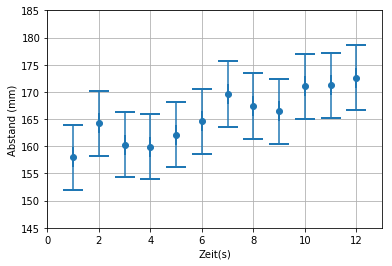

In [25]:
measurements = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6,169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
plt.figure()
plt.errorbar(range(1, 13), measurements, xerr=0, yerr=6, fmt='o', capthick=2, capsize=10)
plt.xlim(0, 13)
plt.ylim(145, 185)
plt.xlabel('Zeit(s)')
plt.ylabel('Abstand (mm)')
plt.grid()

Diese Messdaten passen auf keinen Fall zur einer Hypothese, das Fahrzeug würde sich schräg *auf die Wand zu* bewegen.  
Im folgenden Plot wird eine dazu plausiblere Hypothese mit einer roten Linie visualisiert: Das Fahrzeug bewegt sich exakt parallel zu Wand:

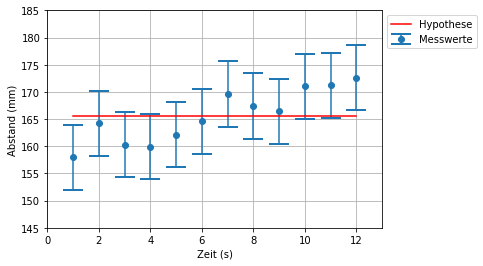

In [26]:
measurements = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
plt.figure()
ave = np.sum(measurements) / len(measurements)
plt.errorbar(range(1,13), measurements, label='Messwerte', yerr=6, fmt='o', capthick=2, capsize=10)
plt.plot([1, 12], [ave,ave], c='r', label='Hypothese')
plt.xlim(0, 13)
plt.ylim(145, 185)
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid()

Die Hypothese im Plot oben überzeugt jedoch auch nicht wirklich: Es gibt keine horizontale Linie, die innerhalb der Fehlerbalken aller Messwerte verläuft.

Im nächsten Plot ist ein linearer "least squares fit" - eine Ausgleichsgerade - als Hypothese eingezeichnet. (Die Gerade wird mit der Methonde ``polyfit()`` aus dem ``NumPy`` Package berechnet.)

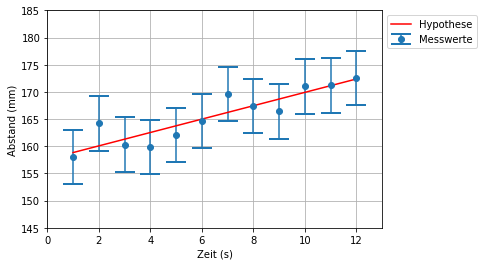

In [27]:
measurements = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
xs = range(1, len(measurements)+1)
line = np.poly1d(np.polyfit(xs, measurements, 1))
plt.figure()
plt.errorbar(range(1, 13), measurements, label='Messwerte',yerr=5, fmt='o', capthick=2, capsize=10)
plt.plot (xs, line(xs), c='r', label='Hypothese')
plt.xlim(0, 13)
plt.ylim(145, 185)
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid()

Diese Hypothese ist bedeutend besser als die vorherige. Das Fahrzeug scheint sich also schräg von der Wand weg zu bewegen und fährt entlang einer geraden Linie. Etwa wie in der Skizze unten dargestellt.

<img src="RoboFahrzeug15Grad.png" width="400">

Glaubt man der roten Linie, dann hat sich das Fahrzeug in der Zeit von 1 s bis 12 s um 13 mm von der Wand weg bewegt.

## Vorhersage des Messwerts aufgrund eines physikalischen Modells
Im Folgenden wird gezeigt, wie mit einem einfachen Modell des Fahrzeugs der nächste Messwert vorhergesagt werden kann. Dabei muss die Vorhersage nicht genau mit der Realität übereinstimmen - es reicht, wenn das Modell in etwa der Realität entspricht. Konkret am Beispiel des Fahrzeugs: Es muss nicht super exakt im vorgegebenen Winkel zur Wand ausgerichtet werden und es darf auch etwas schief fahren. 
Für den oben im Plot dargestellten Bewegungsverlauf wird etwas abweichend zur Ausgleichsgerade angenommen, das Fahrzeug würde sich pro Sekunde um 1 mm von der Wand weg bewegen.  

### Bemerkung zu den Fachbegriffen
In diesem und den folgenden Notebooks werden für den g-h-, Bayes- und Kalman-Filter möglichst immer die selben deutschen Fachbegriffe verwendet. Oft scheitert das Verständnis der Inhalte am Verständis der Fachbegriffe. Daher werden hier und später immer wieder die Fachbegriffe erklärt:  
* Der Ausgabewert eines Filter ist eine Schätzung einer interssierenden Größe wie hier der Abstand zu Wand. Diesen Wert nennt man **Schätzwert (engl. Estimate, Belief)**.
* Filter machen Vorhersagen, sie berechnen dazu einen **Vorhersagewert (engl. Prediction)**. Um Wissenschaftlichkeit vorzuweisen, sprechen deutsche Fachbücher hier auch vom "prädizierten Wert".
* Filter vergleichen ihre Vorhersagen mit **Messwerten**, die im Jargon der Forscher auch gemessene "Zustandswerte oder -vektoren" genannt werden.
* Filter unterziehen dem Vorhersagewert mit Hilfe eines Messwerts einer **Korrektur (engl. Update)**. Daraus entsteht aus dem Vorhersagewert (auch Prior genannt) ein korrigierter Wert (auch Posterior genannt), der zum neuen Schätzwert wird.


### Nur Vorhersage
Der erste Messwert ist wie oben wieder der Abstand 158 mm, gemessen zur Zeit 1 s. Das oben formulierte Modell ermöglicht dann folgende Vorhersage für die Zeit 2 s also für den nächsten Messwert:

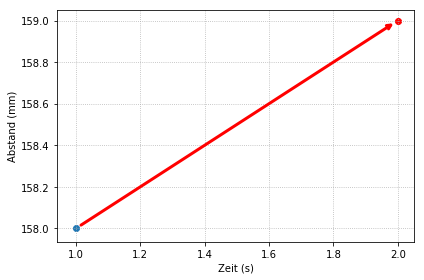

In [28]:
plt.figure()
ax = plt.axes()
ax.annotate('', xy=[2,159], xytext=[1,158], arrowprops=dict(arrowstyle='->', ec='r',shrinkA=6, lw=3,shrinkB=5))
plt.scatter ([1], [158], c='C0')
plt.scatter ([2], [159], c='r')
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
ax.xaxis.grid(True, which="major", linestyle='dotted')
ax.yaxis.grid(True, which="major", linestyle='dotted')
plt.tight_layout()

Eigentlich könnten wir diese Vorhersage (1 mm mehr Wandabstand pro Sekunde) auch für die nächsten zehn Sekunden fortführen. Dies würde aber vermutlich zu einer zunehmenden Diskrepanz zwischen der Vorhersage und dem wahrem Abstandswert führen. Denn das hier zugrunde gelegte Fahrzeugmodell wird sicher nicht exakt der Realität entsprechen!  
Zum Glück gibt es ja für die zweite Messung bei 2 s wieder einen Messwert, der mit der (auf der ersten Messung basierenden) Vorhersage verglichen werden kann.  
### Vorhersage mit anschließender Korrektur durch neuen Messwert
Folgender Plot verdeutlicht den Vergleich des Vorhersagewerts mit dem neuen Messwert. Mit "Schätzwert" ist die erste Messung gemeint. Dass diese Bezeichnung Sinn macht, wird erst dann deutlich, wenn man dieses Verfahren von Messung zu Messung, also jede Sekunde immer erneut anwendet: Dann ist der Ausgangswert für eine Vorhersage immer das Ergebnis der letzten Korrektur des Vorhersagewerts. Wobei die Korrektur jeweils ein Kompromiss zwischen der letzten Vorhersage und dem aktuellen Messwert ist.  
Keine Panik! Später wird diese Rekursion näher erläutert - sie ist der Kernalgorithmus eines Kalman-Filters.

(157, 164.5)

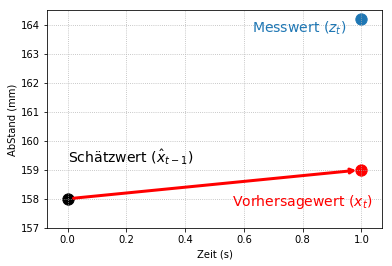

In [29]:
plt.figure()
ax = plt.axes()
ax.annotate('', xy=[1,159], xytext=[0,158],arrowprops=dict(arrowstyle='->',ec='r', lw=3, shrinkA=6, shrinkB=5))
plt.scatter ([0], [158.0], c='k',s=128)
plt.scatter ([1], [164.2], c='C0',s=128)
plt.scatter ([1], [159], c='r', s=128)
plt.text (0.80, 158.2, "Vorhersagewert ($x_t)$", ha='center',va='top',fontsize=14,color='r')
plt.text (0.95, 164.2, "Messwert ($z_t$)",ha='right',va='top',fontsize=14,color='C0')
plt.text (0.0, 159.8, "Schätzwert ($\hat{x}_{t-1}$)", ha='left', va='top',fontsize=14)
plt.xlabel('Zeit (s)')
plt.ylabel('AbStand (mm)')
ax.xaxis.grid(True, which="major", linestyle='dotted')
ax.yaxis.grid(True, which="major", linestyle='dotted')
plt.ylim(157, 164.5)

Wie in den voran gegangenen Beispielen ist die Zeit $t$ eine *diskrete* Größe. Der Einfachheit halber wird eine Diskretisierung von 1 s angenommen: Mit $t=3$ ist also der Zeitpunkt 3 s gemeint. Dann wird mit $t-2$ der Zeitpunkt 1 s oder mit $t+6$ der Zeitpunkt 9 s bezeichnet. Der Index $t$ ist also dimensionslos, wird jedoch gleichzeitig als Variable für die Zeit verwendet. Dies ist zugegeben etwas verwirrend.   

Nun wird der Zeitpunkt $t=1$ näher betrachtet: $\hat x_{t-1} = 158 mm$ bezeichnet den Schätzwert zur Zeit $t-1$, also 0 s, d.h. einer Iteration zuvor. Darauf aufbauend wird die Vorhersage gemacht, dass der Abstand eine Sekunde später zur Zeit  $t = 1$ um 1 mm auf $z_t = 159 mm$ angewachsen ist. Genau zu dieser Zeit liegt aber wieder ein aktueller Messwert $z_t = 164,2 mm$ vor.  
Die Vorhersage und der aktuelle Messwert weichen also voneinander ab. Es gibt hier ein Problem. Aber dies war auch nicht anders zu erwarten.  

**Achtung: In den folgenden Abschnitten werden die Kerngedanken eines Kalman-Filters (hier als Vorstufe der g-h-Filter) formuliert. Nur wer diese Gedanken nachvollziehen kann, wird in den späteren Abschnitten ohne größere Probleme die Idee eines Kalman-Filters verstehen!** 

Alleine nur der aktuellen Messung oder nur der Vorhersage zu vertrauen, macht keinen Sinn. Man würde dann wertvolle Informationen misachten bzw. nicht nutzen.  
>**Die Kernaufgabe besteht nun darin, die Vorhersage und den aktuellen Messwert so zu kombinieren, dass daraus ein Korrekturwert entsteht, welcher vertrauenswürdiger ist als die Vorhersage oder der Messwert alleine.**

Die Kombiantion zweier Größen, die beide einen statistischen Fehler aufweisen, war im Abschnitt *Statische Abstandsmessung* schon einmal Thema. Dort waren es die verrauschten Messwerte zweier Abstandssensoren A und B. Hier ist es eine "verrauschte" Vorhersage und eine verrauschte Messung. Für die Mathematik macht es keinen Unterschied, ob es sich um einen Messwert oder um einen Vorhersagewert handelt. Beide Werte sind *Daten* und können mit einem Erwartungswert und einer Standardabweichung charakterisiert werden.  

Bei den Abstandsmessungen der beiden Sensoren A und B aus der Einleitung dieses Jupyter-Notebooks, wurde deutlich, dass der wahre Wert am wahrscheinlichen im Überlappbereich der beiden Fehlerbalken liegt. Auch wurde kar: Selbst wenn einer der beiden Sensoren sehr stark streut, ist es immer besser beide Sensorwerte zu kombinieren, als nur den mit dem kleinsten Fehlerbalken zu verwenden.  
Auch wenn die Vorhersage nur wenig spezifisch ist, d.h. wenn sie mit einer großen Fehlerbandbreite behaftet ist, auch dann sollte man sie verwenden, um den aktuellen Messwert damit in einen neuen exakteren Schätzwert zu überführen. Man sollte **nie Informationen wegwerfen**!

**Entscheidend ist nun, *wo* der Korrekturwert $\hat x_t$ zwischen dem Vorhersagewert $\bar x_t$ und dem aktuellen Messwert $z_t$ verortet wird.** Näher an der Vorhersage oder näher am aktuellen Messwert? Dies verdeutlicht der nachfolgende Plot, in dem der Korrekturwert willkürlich näher an den Vorhersagewert platziert wurde.

(157, 164.5)

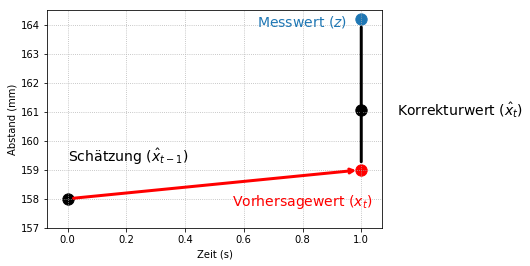

In [30]:
plt.figure()
ax = plt.axes()
ax.annotate('', xy=[1,159], xytext=[0,158], arrowprops=dict(arrowstyle='->',
            ec='r', lw=3, shrinkA=6, shrinkB=5))
ax.annotate('', xy=[1,159], xytext=[1,164.2], arrowprops=dict(arrowstyle='-',
            ec='k', lw=3, shrinkA=8, shrinkB=8))
est_y = (159 + .4*(164.2-159))
plt.scatter ([0,1], [158.0,est_y], c='k',s=128)
plt.scatter ([1], [164.2], c='C0',s=128)
plt.scatter ([1], [159], c='r', s=128)
plt.text (0.80, 158.2, "Vorhersagewert ($x_t)$", ha='center',va='top',fontsize=14,color='r')
plt.text (0.95, 164.4, "Messwert ($z$)",ha='right',va='top',fontsize=14,color='C0')
plt.text (0, 159.8, "Schätzung ($\hat{x}_{t-1}$)", ha='left', va='top',fontsize=14)
plt.text (1.55, est_y, "Korrekturwert ($\hat{x}_{t}$)", ha='right', va='center',fontsize=14)
plt.xlabel('Zeit (s)')
plt.ylabel('Abstand (mm)')
ax.xaxis.grid(True, which="major", linestyle='dotted')
ax.yaxis.grid(True, which="major", linestyle='dotted')
plt.ylim(157, 164.5)

### Anmerkung zur Notation:  
Die Größen $z$ sind immer Messwerte. Die Größen $\bar x$ mit Blaken sind immer Vorhersagen und die Größen $\hat x$ mit Dach sind die aus den Messwerten und Vorhersagen errechneten Korrekturwerte.  
Wie vorhin schon erwähnt, ist es anfangs etwas verwirrend, den ersten Messwert zur Zeit 0 s auch als Schätzwert zu bezeichnen. Dies beruht darauf, dass nur ganz am Anfang ein Messwert als erster Schätzwert verwendet werden muss, weil kein vorheriger Korrekturwert vorhanden ist. In den nächsten Iterationsrunden, liegt jedoch immer ein letzter Korrekturwert als Startpunkt für die nächste Iteration vor.

## Entwicklung eines Filters
Im Plot oben wurde der Einfachheit halber angenommen, der aktuelle Messwert habe eine 1,5-fach so große statistische Unsicherheit wie die Vorhersage. Daher wird der Korrekturwert "von der Vorhersage auf 40 % in Richtung aktueller Messwert" gesetzt. Anders ausgedrückt: Der Korrekturwert errechnet sich zu 60 % aus der Vorhersage und zu 40 % aus dem aktuellen Messwert. Der Vorhersage wird also mehr vertraut als dem aktuellen Messwert. Mathematisch wird dies so formuliert:

$$\text{Korrekturwert} = \text{Vorhersagewert} + \frac{4}{10}\text{(Messwert - Vorhersagewert)}$$

Die Differenz zwischen dem Vorhersage- und dem Messwert nennt man "Residuum" (englisch "*residual*"). Im Plot oben ist dieser Wert mit der schwarzen vertikalen Linie visualisiert.  
### g-h-Filter unter Optimalbedingungen
**Die oben genannte Berechnung des Korrekturwerts aus der letzten Schätzung und dem aktuellen Messwert ist der erste Schritt zu einem g-h-Filter.**  
Im folgenden Quellcode wird dieser Filter 12 mal iterativ angewendet: Der letzte Korrekturwert ist dabei immer der neue Schätzwert für die nächste Iteration. Da 12 Messwerte und ein Startwert existieren, kann der Filter 12 mal angewendet werden.  
Für jede Iteration werden die verschiedenen Parameter in Textform ausgegeben. Die Vorhersage basiert nach wie vor auf der Tatsache, dass sich das Fahrzeug um 1 mm pro Sekunde von der Wand weg bewegt. Der Vorhersagewert ist also immer um 1 größer als der Schätzwert.  

Wieder taucht hier die Frage auf, woher der erste Schätzwert herkommt. Dieser Startwert wird nun einfach geraten: Es wird angenommen, das Fahrzeug befinde sich zu Beginn in einem Abstand von 160 mm zur Wand.

In [31]:
measurements = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]

scale_factor = 4.0/10

# filter function will be used later again
def filter(zero_estimate, variation):     
    # store the filtered results
    estimates, predictions = [zero_estimate], []
    estimate = zero_estimate
    # most filter literature uses 'z' for measurements
    for measurement in measurements:
        # predict new position
        old_estimate = estimate
        prediction = estimate + variation         
        # update filter: Neuen Schätzwert berechnen
        estimate = prediction + scale_factor * (measurement - prediction)
        # save
        estimates.append(estimate)
        predictions.append(prediction)
        print('Schätz.: {:.2f},  Vorhers.: {:.2f},  Mess.: {:.2f},  Korrekt.: {:.2f}'.
            format(old_estimate, prediction, measurement, estimate))
    return estimates, predictions

initial_guess = 160.0

estimates, predictions = filter(zero_estimate=initial_guess, variation=1)     

Schätz.: 160.00,  Vorhers.: 161.00,  Mess.: 158.00,  Korrekt.: 159.80
Schätz.: 159.80,  Vorhers.: 160.80,  Mess.: 164.20,  Korrekt.: 162.16
Schätz.: 162.16,  Vorhers.: 163.16,  Mess.: 160.30,  Korrekt.: 162.02
Schätz.: 162.02,  Vorhers.: 163.02,  Mess.: 159.90,  Korrekt.: 161.77
Schätz.: 161.77,  Vorhers.: 162.77,  Mess.: 162.10,  Korrekt.: 162.50
Schätz.: 162.50,  Vorhers.: 163.50,  Mess.: 164.60,  Korrekt.: 163.94
Schätz.: 163.94,  Vorhers.: 164.94,  Mess.: 169.60,  Korrekt.: 166.80
Schätz.: 166.80,  Vorhers.: 167.80,  Mess.: 167.40,  Korrekt.: 167.64
Schätz.: 167.64,  Vorhers.: 168.64,  Mess.: 166.40,  Korrekt.: 167.75
Schätz.: 167.75,  Vorhers.: 168.75,  Mess.: 171.00,  Korrekt.: 169.65
Schätz.: 169.65,  Vorhers.: 170.65,  Mess.: 171.20,  Korrekt.: 170.87
Schätz.: 170.87,  Vorhers.: 171.87,  Mess.: 172.60,  Korrekt.: 172.16


Die Ergebnisse der 12 Iterationen oben werden nun grafisch in folgendem Plot dargestellt:

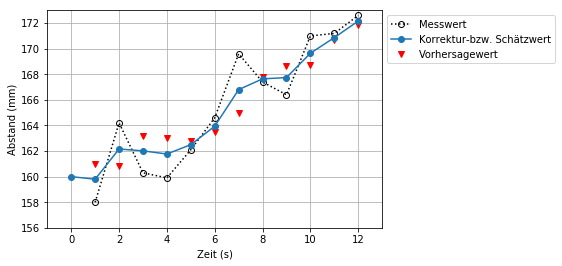

In [32]:
# filter data plot function will be used later again
def plot_filter(measurements, estimates, predictions):
    plt.figure()
    n = len(measurements)
    xs = range(n+1)
    pred, = plt.plot(xs[1:], predictions, c='r', marker='v', linestyle='None')
    meas, = plt.plot(xs[1:], measurements, color='k', marker = 'o', linestyle=':', mfc='None')
    est, = plt.plot(xs, estimates, marker='o')  
    plt.legend([meas, est, pred], ['Messwert', 'Korrektur-bzw. Schätzwert', 'Vorhersagewert'],
               loc="upper left", bbox_to_anchor=(1,1))
    plt.xlabel('Zeit (s)')
    plt.ylabel('Abstand (mm)')
    plt.xlim([-1, n+1])
    plt.ylim([156.0, 173])
    plt.grid()

plot_filter(measurements, estimates, predictions)

Die blaue Kurve mit den Schätzwerten ist der Output des g-h-Filters. Sie beginnt mit dem geratenen Startwert von 160 mm für den "ersten Schätzwert" des Abstands.  
Es ist gut sichtbar, dass der aktuelle Schätzwert (blauer Vollkreis) immer doppelt so nahe am Vorhersagewert (rotes Dreieck) liegt wie am aktuellen Messwert (schwarzer Kreis). Die Schätzwerte liegen nicht auf einer geraden Linie, wie die wahren Werte des Fahrzeugs, welches sich leicht schräg von der Wand weg bewegt. Ihre Spur (blaue Linie) ist aber deutlich weniger holprig als die der Messwerte (gepunktete schwarze Linie).  

Dieser einfache Filter zeigt also eine erstaunliche Wirkung. Dies hängt nicht unbedingt vom richtig geratenem Startwert oder vom exakt erstellten physikalischen Modell (hier die vorgegebene Steigung `variation`) ab. 
### g-h-Filter mit schlechtem Startwert
Folgende Plots untersuchen nun die Robustheit des Filters. Zuerst wird ein anderer Startwert `initial_guess` verwendet, welcher stark von der wahren Startposition abweicht: 

Schätz.: 164.00,  Vorhers.: 165.00,  Mess.: 158.00,  Korrekt.: 162.20
Schätz.: 162.20,  Vorhers.: 163.20,  Mess.: 164.20,  Korrekt.: 163.60
Schätz.: 163.60,  Vorhers.: 164.60,  Mess.: 160.30,  Korrekt.: 162.88
Schätz.: 162.88,  Vorhers.: 163.88,  Mess.: 159.90,  Korrekt.: 162.29
Schätz.: 162.29,  Vorhers.: 163.29,  Mess.: 162.10,  Korrekt.: 162.81
Schätz.: 162.81,  Vorhers.: 163.81,  Mess.: 164.60,  Korrekt.: 164.13
Schätz.: 164.13,  Vorhers.: 165.13,  Mess.: 169.60,  Korrekt.: 166.92
Schätz.: 166.92,  Vorhers.: 167.92,  Mess.: 167.40,  Korrekt.: 167.71
Schätz.: 167.71,  Vorhers.: 168.71,  Mess.: 166.40,  Korrekt.: 167.79
Schätz.: 167.79,  Vorhers.: 168.79,  Mess.: 171.00,  Korrekt.: 169.67
Schätz.: 169.67,  Vorhers.: 170.67,  Mess.: 171.20,  Korrekt.: 170.88
Schätz.: 170.88,  Vorhers.: 171.88,  Mess.: 172.60,  Korrekt.: 172.17


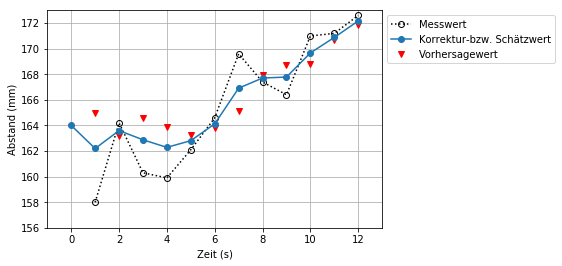

In [33]:
wrong_initial_guess = 164.0
right_variation = 1
estimates, predictions = filter(zero_estimate=wrong_initial_guess, variation=right_variation)
plot_filter(measurements, estimates, predictions)

Ein schlechterer Startwert lässt den Filter nur während der ersten Iterantionen vom wahren Bewegungsverlauf deutlich abweichen, wie der Plot oben verdeutlicht. Der Filter korrigiert sich danach aber schnell selbst.  
### g-h-Filter mit schlechtem Startwert und schlechtem physikalischen Modell
Im folgenden Plot ist zusätzlich ein schlechtes physikalisches Modell angenommen: Die Abstandszunahme `variation` wird als -1 mm statt 1 mm pro Sekunde angenommen. Das Modell nimmt also an, das Fahrzeug würde schräg auf die Wand zu fahren!

Schätz.: 184.00,  Vorhers.: 185.00,  Mess.: 158.00,  Korrekt.: 174.20
Schätz.: 174.20,  Vorhers.: 175.20,  Mess.: 164.20,  Korrekt.: 170.80
Schätz.: 170.80,  Vorhers.: 171.80,  Mess.: 160.30,  Korrekt.: 167.20
Schätz.: 167.20,  Vorhers.: 168.20,  Mess.: 159.90,  Korrekt.: 164.88
Schätz.: 164.88,  Vorhers.: 165.88,  Mess.: 162.10,  Korrekt.: 164.37
Schätz.: 164.37,  Vorhers.: 165.37,  Mess.: 164.60,  Korrekt.: 165.06
Schätz.: 165.06,  Vorhers.: 166.06,  Mess.: 169.60,  Korrekt.: 167.48
Schätz.: 167.48,  Vorhers.: 168.48,  Mess.: 167.40,  Korrekt.: 168.05
Schätz.: 168.05,  Vorhers.: 169.05,  Mess.: 166.40,  Korrekt.: 167.99
Schätz.: 167.99,  Vorhers.: 168.99,  Mess.: 171.00,  Korrekt.: 169.79
Schätz.: 169.79,  Vorhers.: 170.79,  Mess.: 171.20,  Korrekt.: 170.96
Schätz.: 170.96,  Vorhers.: 171.96,  Mess.: 172.60,  Korrekt.: 172.21


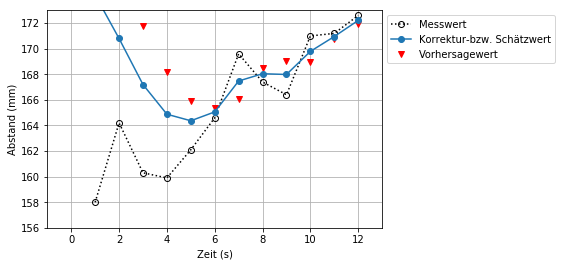

In [34]:
wrong_initial_guess = 184.0
wrong_variation = 1
estimates, predictions = filter(zero_estimate=wrong_initial_guess, variation=wrong_variation)
plot_filter(measurements, estimates, predictions)

Anders als bei einem schlechten Startwert wirft ein schlechtes physikalisches Modell in Form eines ungünstigen Parameters `variation` unseren Filter aus der Bahn. Dies ist auch der Fall, wenn der Startwert richtig gewesen wäre. Trotzdem liegt der Filter nicht ganz und gar falsch: Obwohl das physikalische Modell ihm nahelegt, das Fahrzeug würde schräg auf die Wand zu fahren, macht der Filter dennoch die realitätsnahe Vorhersage eines *Wegfahrens* von der Wand. Dies jedoch mit einem deutlichen Offset zum wahren Bewegungsverlauf. 

### g-h-Filter mit adaptivem Modellparameter für die Abstandsänderung
Unser Filter muss also noch etwas anpassungsfähgier werden: Er muss während seiner Ausführung Parameter des physikalischen Modells optimieren können.  
Konkret heißt das: Das physikalische Modell selbst nimmt nur an, das Fahrzeug bewege sich geradlinig. in welchem Winkel das Fahrzeug zur Wand hin oder weg fährt, wird adaptiv durch einen Parameter dieses Modells bestimmt. Für diesen Parameter gibt es schon die Variable `variation` für die Abstandsänderung zur Wand. Der Wert dieser Variablen sollte durch den Filter selbst aufgrund der Messdaten optimiert werden können.  
#### Vorüberlegungen
Zurück zum ersten Plot des Filterverlaufs mit Startwert 160 mm und Abstandsänderung von 1 mm/s:  
Die Vorhersage hier für den ersten Messwert zur Zeit 1 s lautet:

$$(160 + 1) mm + \frac{4}{10}(158 mm-161 mm) = 159.8 mm$$

Tatsächlich wird zu dieser Zeit aber ein Abstand von 164,2 mm gemessen, was eine tatsächliche Abstandsänderung *nicht* von 1 mm/s sondern von 4,4 mm/s nahelegt. Diese Information zur Abstandsänderung ist zwar verrauscht aber immer noch nützlicher als die aus der Luft gegriffene Annahme, das Fahrzeug würde sich ein für alle mal mit 1 mm/s von der Wand entfernen.  

>Informationen aus Messdaten sind aber nützlicher als bloße theoretische Annahmen, selbst wenn die Messdaten stark verrauscht sind. Daher sollte man keine Sensordaten verwerfen, sondern sie nutzen!

Nun ist folgende Frage berechtigt: Es werden ja schon alle Sensormesswerte genutzt, um damit einen neuen Schätzwert für den Abstandswert zu bilden.  
>**Frage:** Welche Information wird verworfen, wenn die zeitliche Änderung der Messdaten nicht genutzt wird? Wofür ist die zeitliche Änderung nützlich?  
**Antwort:** Die zusätzliche Information steckt in der *zeitlichen Korrelation der Messwerte, mit Hilfe eines physikalischen Modells wird damit der zukünftiger Verlauf der Messdaten extrapoliert*.

Mit welchem Algorithmus kann man den Parameter `variation` der Abstandsänderung flexibel gestalten, so dass er sich aufgrund des Messwertverlaufs selbst optimiert?  
Es ist naheliegend, hier genau so zu verfahren, wie bei der Berechnung des neuen Schätzwerts aus dem aktuellen Messwert und der Vorhersage für den Abstand:  
Wurde vorher die Abstandsänderung als 1 mm/s angenommen und stellt sich aufgrund des aktuellen Messwertes heraus, dass sie im Vergleich zum vorherigen Messwewrt 4,4 mm/s beträgt, so wird für die nächste Iteration (=Abtastung) eine Abstandsänderung zwischen diesen beiden Werten angenommen.  Man verfährt mit der Abstandsänderung also genauso wie mit dem Abstand selbst.

Analog wie bei der Verrechnung des aktuellen Messwerts mit der Vorhersage wird die neue Abstandsänderung zu 70 % aus der  alten und zu 30 % aus der Abweicheung Messwert zu Vorhersage berechnet. Je besser die Vorhersage den aktuellen Messwert voraussagt, desto weniger wird die aktuelle Abstandsänderung geändert. Die konkreten Prozentwerte hier sind willkürlich - also wieder ein Schuss aus der Hüfte.  

#### Adaptiver g-h-Filter mit schlechtem Startwert und schlechtem physikalischen Modell
Die hieraus resultierende Gleichung für die Abstandsänderung ist somit der für den neue Schätzwert des Messwerts "Abstand" sehr ähnlich:

$$\text{neue Abstandsänderung} = \text{alte Abstandsänderung} + \frac{1}{3}\frac{\text{aktuelle Messung - Vorhersage}}{ \text{s}}$$

Zusätzlich zum ersten Schätzwert für den Wandabstand muss jetzt auch die erste Abstandsänderung "geraten" werden. 

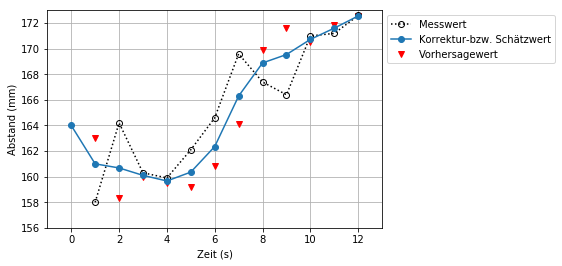

In [36]:
initial_guess_meas = 164.
initial_guess_variation = -1.0 
meas_scale = 4./10
var_scale = 1./3
estimates = [initial_guess_meas]
predictions = []

variation = initial_guess_variation
measurement = initial_guess_meas

for z in measurements:
    # prediction step
    measurement = measurement + variation
    variation = variation # the model gives no prediction for the variation
    predictions.append(measurement)
    
    # update step    
    residual = z - measurement
    variation = variation + var_scale * residual # model parameter gain is updated
    measurement    = measurement    + meas_scale * residual # new estimade is calculated
  
    estimates.append(measurement)

plot_filter(measurements, estimates, predictions)

Jetzt macht der Filter wirklich gute Arbeit: Trotz falsch angenommenem Abstand und Abstandsänderung beim Start dauert es nur wenige Sekunden, bis der Filter die Abstandswerte sehr realitätsnah ausgibt. Dann "trackt" sozusagen die  Abstandsmesswerte.  
Die beiden Skalierungsfaktoren `meas_scale` und `var_scale` $\frac{4}{10}$ bzw. $\frac{1}{3}$ sind aus der Hüfte geschossen - funktionieren aber trotzdem sehr gut. Sie bleiben die einzig willkürlich gewählten Parameter des Filters.  

Die Codezeile
```python
variation = variation
``` 
soll verdeutlichen, dass iterativ nur Vorhersagen des Messwerts "Abstand" nicht aber Vorhersagen der Abstandsänderung gemacht werden. Denn bis hierhin wurde ein physikalisches Modell verwendet, bei dem es keine Aussage über einen zeitlichen Verlauf der Abstands*änderung* gibt. Anders ausgedrückt, das Fahrzeug fährt an sich nur geradlinig mit konstanter Geschwindigkeit zur Wand hin, von der Wand weg oder parallel dazu.  

## Der g-h-Filter

Den im vorherigen Abschnitt nun fertig entwickelten Filteralgorithus bezeichnet man als **g-h-Filter** oder auch $\alpha$-$\beta$-Filter.  
**Die Buchstaben $g$ und $h$ stehen für die beiden beiden Skalierungsfaktoren ``meas_scale`` und ``var_scale``**,  $\alpha$ und $\beta$ sind nur andere Bezeichnungen dieser Faktoren.  
Der g-h-Filter ist die Basis für verschiedenste Filteralgorithmen, die bei der Sensordatenverarbeitung zur Anwendung kommen. **Auch der Kalman-Filter ist eine Spezialform des g-h-Filters**.

Zum Ende dieser Einführung in die Welt der Kalman-Filter werden nun die bis hierhin behandelten Kernthesen wiederholt. Es ist absolut wichtig, diese zu verstehen, wenn ein Kalman-Filter eingesetzt werden soll.  
>*Denn ist verantwortungslos für einen Ingenieur, so wie es derzeit in der künstlichen Intelligenz geschieht, Algorithmen in den Verkehr zu bringen, indem man nur deren Bibliotheken verwendet. Man muss nachvollzogen haben, wie die Algorithmen funktionieren!*   


**Hier sind nochmals die Kernthesen**. Das Notebook zum Kalman-Filter lässt sich nur damit verstehen.

* Viele Messdaten sind immer genauer als das Ergebnis nur einer Einzelmessung. Daher sind Messdaten niemals zu verwerfen, auch wenn diese eine sehr hohe Messunsicherheit besitzen.
* Gibt es zwei verrauschte Werte für eine Messgröße, dann liegt irgendwo zwischen ihnen ein Schätzwert mit einer geringeren Messunsicherheit, als jeder der beiden Werte besitzt.
* Der nächste Messwert wird auf Basis eines physikalischen Modells vorhergesagt. Parameter dieses Modells werden unter Berücksichtigung des vergangenen Messwertverlaufs angepasst.
* Der Korrekturwert liegt zwischen dem vorhergesagten Wert und dem aktuellen Messwert. Ist einer dieser beiden Datenpunkte weniger verrauscht, dann liegt der neue Korrekturwert näher bei ihm.
* In der nächsten Iteration wird der Korrekturwert als neuer Schätzwert verwendet.


In folgender Grafik ist der Algorithmus des g-h-Filters verdeutlicht. Er besteht aus einer Initialisierung mit Startwerten und anschließenden Iterationen. Zu jeder Iteration (=Abtastung) kommt ein neuer Messwert hinzu und neue Schätzwerte werden vom Filter ausgegeben.

![title](gh_AlgoGrafik.png)

Die Variablen $\hat x_0$, $z_k$ und $\hat x_k$ in diesem Diagramm sind Vektoren. Ein Filter, der nur eine Größe wie hier den Abstand trackt, nennt man *eindimensionalen* Filter. Dann werden aus den Vektoren Skalare, haben also nur das Element 0. Nachfolgend wird daher immer nur das Element 0 des entsprechenden Vektors erwähnt.

1) Zu Beginn müssen (geratene) Startwerte für den Abstand *und* für die Abstandsänderung vorliegen. Diese sind die beiden Elemente des Vektors $\hat x_0$. Es folgt eine Vorhersage für den nächsten Abstandsmesswert basierend auf diesen beiden Startwerte. Im Korrekturschritt erfolgt eine Messung, aus der zusammen mit dem Vorhersagewert ein Korrekturwert für den Abstand sowie für die Abstandsänderung generiert wird. Diese beiden Korrekturwerte werden schließlich als neue Schätzwerte verwendet. Der Abstandskorrekturwert wird als Element 0 des Vektors $\hat x_1$ vom Filter ausgegeben.  

2) Jetzt beginnt die nächste Iteration: Im Vorhersageschritt wird mit dem Schätzwert für den Abstand und für die Abstandsänderung ein neuer Vorhersagewert für den Abstand berechnet. Danach im Korrekturschritt erfolgt eine neue Messung, mit der neue Korrekturwerte für den Abstand und die Abstandsänderung berechnet werden. Der Korrekturwert des Abstand wird als Element 0 des Schätzwerts $\hat x_2$ ausgegeben.  

3) Dann beginnt eine neue Iteration...

## Übliche Begriffe rund um einen g-h-Filter

Bei Lehrbüchern zum Kalmanfilter liegen die großen Verständnishürden erstens in der verallgemeinerten Matrizenrechnung und zweitens in den verwendeten Fachbegriffen. Zumindest die Verwirrung durch die Begrifflichkeiten kann jetzt anhand der vorangegangenen Betrachtungen aufgeklärt werden. Dazu wird das Beispiel des Roboterfahrzeugs verwendet.

* **Das *System* oder der *Prozess* besteht hier aus dem Roboterfahrzeug, dem Fußboden auf dem es fährt und aus der Wand an der es entlang fahren soll.**

* **Der *Zustand* des *Systems* ist die Eigenschaft oder der Wert des Systems die uns (oder beispielsweise eine Regelung) interessiert.** In hier vorliegendem Fall ist dies nur der Abstand des Fahrzeugs zur Wand, nicht jedoch die Abstandsänderung. Ein Zustand ist nicht immer von außen sichtbar. Oft wird er erst duch eine Messung sichtbar, die den entsprechenden *Messwert* dazu generiert. Es ist der wahre Wert einer Messgröße. Andere Eigenschaften unseres Systems wie die Masse des Fahrzeugs oder dessen Geschwindigkeit sind kein *Zustand*, da sie aktuell nicht interessieren.

* **Der *Messwert* des *Systems* ist der gemessene *Zustand* des *Systems*.** Hier ist es der gemessene Abstand zur Wand. Diese Messwert ist fehlerbehaftet im Gegensatz zum *Zustand*, der den wahren Wert für den Abstand zur Wand darstellt. Sensoren erfassen Zustände und generieren daraus fehlerbehaftete *Messwerte* für bestimmte Messgrößen - hier der Abstandssensor für die Messgröße "Abstand".

* **Der *Zustandsschätzwert* oder auch *Zustandswert* ist der durch den Filter geschätzte Wert des *Zustands*.**

* **Das *Prozessmodell* wird verwendet, um das System mathematisch zu modellieren.** Hier ist das identisch zum physikalische Modell des Fahrzeugs, welches sich mit konstanter Geschwindigkeit geradlinig bewegt. 

* Kein Modell bildet ein *System* fehlerfrei ab. Diese Abweichungen des Modells nennt man **Systemfehler** bzw. **Prozessfehler**. Im Fall des hier behandelten Fahrzeugs führen unterschiedliche Drehzahlen der Räder auf der linken und rechten Seite z.B. dazu, dass das Fahrzeug eine Kurve fährt, was vom *Prozessmodell* nicht abgebildet wird.

* **Der Vorhersageschritt wird auch *Systempropagation* oder *Prädiktion* genannt:** Das *Prozessmodell* erzeugt im Vorhersageschritt einen neuen *Zustandsschätzwert*, welcher nicht zuletzt aufgrund des *Prozessfehlers* fehlerbehaftet ist.

* **Der Korrekturschritt wird meist *Update* genannt.**

* Ein Iterationsschritt aus *Systempropagation* und *Update* nennt man *Epoche*.

## Mathematische Notation
Nicht ganz so verwirrend wie die Begrifflichkeiten sind die mathematischen Symbole und Variabelnamen in den verschiedenen Lehrbüchern. In diesem Notebook werden die üblichen Notationen verwendet.

* **Ein Messwert wird mit der Variablen $z$ bezeichnet.**  
* **Ein Index $k$ steht für einen Zeitschritt.** $z_k$ bezeichnet den Messwert zur Zeit $k$. Beispielsweise bei einer Abtastperiode von einer Sekunde ist $z_{20}$ der Messwert zur Zeit 20 Sekunden.  
* **Der Systemzustand wird mit der Variablen $x$ bezeichnet.** 
* **Fett gedruckte Variablennamen bezeichnen Vektoren.** Wenn mehrere unterschiedliche Messgrößen erfasst werden, dann wird der Skalar $z_k$ zu einem Vektor $\mathbf{z_k}$. Auch der Systemzustand kann ein Vektor sein und wird dann mit $\mathbf{x}$ bezeichnet.
* **Schätzwerte des Systemzustands werden mit einem Dach ($\hat{ } $) über dem $x$ gekennzeichnet: $\mathbf{\hat x}$.** Genau wie der Systemzustand können sie auch Vektoren sein.
* **Der Startwert für den Systemzustand wird mit dem Index $0$ bezeichnet, also mit $\mathbf{\hat x_0}$.** Genau wie der Schätzwert kann er auch ein Vektor sein.
* Der Skalierungsfaktor **g** bestimmt, in welchem Verhältnis der Vorhersage- und der Messwert gewichtet werden.
* Der Skalierungsfaktor **h** auch "Gain" genannt bestimmt, wie der Parameter der Zuständsänderung im physikalischen Modell an die vorliegende Messwertänderung angepasst wird.

>**Die Kernidee des g-h-Filters ist es, fehlerbehaftete Messwerte mit einem fehlerbehafteten Modell des gemessenen Systems so zu kombinieren, dass Schätzwerte entstehen, die weniger fehlerbehaftet sind als das Modell oder die Messwerte alleine.**